In [40]:
%pylab inline
import numpy as np
import pandas as pd
import os, sys
import random
import networkx as nx
import matplotlib.pyplot as plt
import SAD as sad

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist', 'norm', 'random', 'hist', 'pareto']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0.004624817448509177 4.9247319856809677e-05


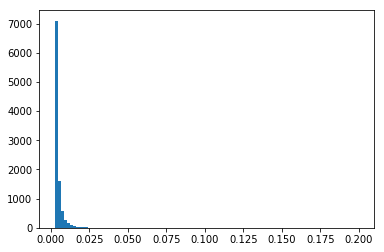

In [41]:
N = 10000
# produce activities 
from scipy.stats import norm,pareto
b = 2.1
dist = pareto(b).rvs(100000)
dist = np.random.choice(dist,N)
act = dict(zip(range(N),dist/(5.0*np.max(dist))))
plt.hist(act.values(),100)
mu, v  = np.mean(act.values()), np.mean(np.array(act.values())**2)
print mu, v

In [199]:
import imp
imp.reload(sad)

<module 'SAD' from 'SAD.py'>

In [200]:
N = 100
T = 2000
k = 4

In [201]:
STG, hist = sad.memory_temporal_graph_creation(N,T,k,act,mode='network',alpha=1,returnhist=True)
STGm, histm = sad.memory_temporal_graph_creation(N,T,k,act,mode='simplicial',alpha=1,returnhist=True)

In [202]:
def clean_filtration(hist):
    acc = []
    clean_hist = {}
    for t in hist:
        clean_hist[t] = []
        for el in hist[t]:
            if frozenset(el) not in acc: #checks for repeated simplices
                test = [frozenset(el).issubset(x) for x in acc]; 
                if np.sum(test)==0: #checks new simplex is not included in another already present;
                    clean_hist[t].append(el);
                    acc.append(frozenset(el));
    return clean_hist;   

def hist_to_fil(ch):
    import itertools
    Clique_dictionary = {}
    for i, t in enumerate(ch.keys()):
        for clique in ch[t]:
            for k in range(1,len(clique)+1): #loop on clique dimension to find missed faces of simplex
                for subclique in itertools.combinations(clique,k):
                    if str(list(subclique)) not in Clique_dictionary:
                        Clique_dictionary[str(list(subclique))]=[];
                        Clique_dictionary[str(list(subclique))].append(str(i));
                        Clique_dictionary[str(list(subclique))].append(str(t))
    return Clique_dictionary;

In [203]:
chistm = clean_filtration(histm)
chist = clean_filtration(hist)

print np.sum(map(len, histm.values())), np.sum(map(len, chistm.values()))

# sh = histm.keys()
# shuffle(sh)
# hist = {}
# for i,t in enumerate(sh):
#     hist[i] = histm[t];

# chist = clean_filtration(hist)
print np.sum(map(len, hist.values())), np.sum(map(len, chist.values()))


993 369
5509 1763


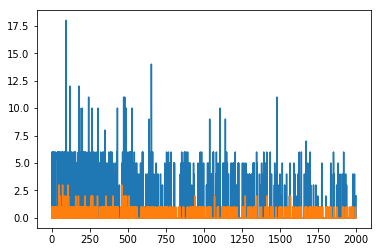

In [204]:
plt.plot(map(lambda x: len(chist[x]), chist.keys()))
plt.plot(map(lambda x: len(chistm[x]), chistm.keys()))

In [205]:
%%sh 
mkdir ../data/activity-driven-phom/
mkdir ../data/activity-driven-phom/hists
mkdir ../data/activity-driven-phom/output

mkdir: ../data/activity-driven-phom/: File exists
mkdir: ../data/activity-driven-phom/hists: File exists
mkdir: ../data/activity-driven-phom/output: File exists


In [206]:
import cPickle as pk
pk.dump(hist_to_fil(chistm),open('../data/activity-driven-phom/hists/histm.pck','w'))
pk.dump(hist_to_fil(chist),open('../data/activity-driven-phom/hists/hist.pck','w'))

In [207]:
sys.path.append('/Users/lordgrilo/Dropbox/')
import Holes as ho

In [208]:
ho.persistent_homology_calculation('../data/activity-driven-phom/hists/histm.pck',2,'memory',
                                   '../data/activity-driven-phom/output/')
ho.persistent_homology_calculation('../data/activity-driven-phom/hists/hist.pck',2,'nomemory',
                                   '../data/activity-driven-phom/output/')

Calling: jython  /Users/lordgrilo/Dropbox/Holes/jython_utils/persistent_homology_calculation.py ../data/activity-driven-phom/hists/histm.pck 2 ../data/activity-driven-phom/output/ memory_ /Users/lordgrilo/Dropbox/Holes/jython_utils/lib False


Child returned 0


Calling: jython  /Users/lordgrilo/Dropbox/Holes/jython_utils/persistent_homology_calculation.py ../data/activity-driven-phom/hists/hist.pck 2 ../data/activity-driven-phom/output/ nomemory_ /Users/lordgrilo/Dropbox/Holes/jython_utils/lib False


Child returned 0


In [209]:
gen = pk.load(open('../data/activity-driven-phom/output/gen/generators_nomemory_.pck'))
memgen = pk.load(open('../data/activity-driven-phom/output/gen/generators_memory_.pck'))

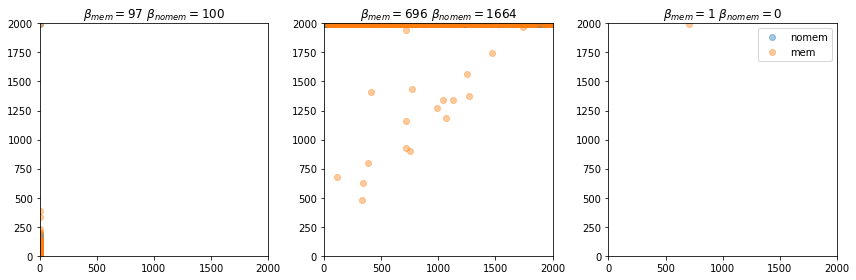

In [210]:
dims = [0,1,2];
fig = plt.figure(figsize=(12,4))
for dim in dims:
    plt.subplot(1,len(dims),dim+1);
    plt.plot(map(lambda x: float(x.start), gen[dim]),map(lambda x: float(x.end), gen[dim]),'o',label='nomem',alpha=.4)
    plt.plot(map(lambda x: float(x.start), memgen[dim]),map(lambda x: float(x.end), memgen[dim]),'o',label='mem', alpha=.4)
    plt.xlim(0,2000)
    plt.ylim(0,2000)
    plt.title(r'$\beta_{mem} =$'+str(len(memgen[dim]))+r' $\beta_{nomem} =$'+str(len(gen[dim])))
plt.legend(loc=0)
plt.tight_layout()

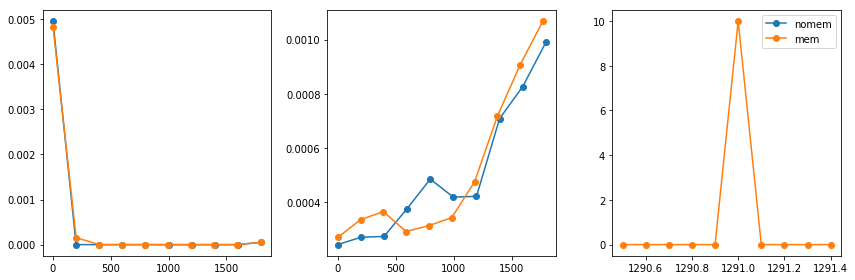

In [211]:
dims = [0,1,2];
fig = plt.figure(figsize=(12,4))
for dim in dims:
    plt.subplot(1,len(dims),dim+1);
    aa, bb = np.histogram(map(lambda x: x.persistence_interval(), gen[dim]),normed=True)
    plt.plot(bb[:-1],aa,'o-',label='nomem')
    aa, bb = np.histogram(map(lambda x: x.persistence_interval(), memgen[dim]),normed=True)
    plt.plot(bb[:-1],aa,'o-',label='mem')

plt.legend(loc=0)
plt.tight_layout()